# Import Libs

In [ ]:
import random
import pandas as pd
import numpy as np


# 0. Preparation (Setting the Random State)

In [ ]:
rs = min(289456, 274211)
np.random.seed(rs)

# Exercise 1 (Loading and Preparing the Data)

In [ ]:
# 1.1 Load the CSV file into a pandas DataFrame
df_tot = pd.read_csv('cla4lsp_customers.csv', sep='\t')

# 1.2 Create a sub-DF workdf with 2/3 of the original dataframe's rows (randomly sampled)
workdf = df_tot.sample(frac=2 / 3, random_state=rs)
# 1.3 hard-code labels and feature
labels = ['NumDealsPurchases', 'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4',
          'AcceptedCmp5', 'Recency', 'Complain', 'Recency']
features = ['Education', 'Marital_Status', 'Year_Birth', 'Income', 'Kidhome', 'Teenhome', 'Dt_Customer', 'MntWines',
            'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumWebPurchases',
            'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth']
columns_to_remove = ['ID', 'Z_CostContact', 'Z_Revenue']
# 1.4 Remove one feature column randomly from spending or purchasing habits
spending_columns = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts',
                    'MntSweetProducts', 'MntGoldProds', 'NumWebPurchases',
                    'NumCatalogPurchases', 'NumStorePurchases']
col_to_remove = np.random.choice(spending_columns)
columns_to_remove.append(col_to_remove)
print("Random Column to be dropped: ", col_to_remove)
features.remove(col_to_remove)
workdf.drop(columns_to_remove, axis=1, inplace=True)

In [ ]:
workdf.isnull().sum()

Since we have missing values in the income column we drop the missing values

In [ ]:
# 1.5 Clean the dataset from missing values in the feature columns
workdf.dropna(inplace=True)
workdf.isnull().sum()


# Exercise 2 (Encoding of Categorical Data)

In [ ]:
categorical_columns = list(workdf.select_dtypes(include=['object']).columns)
categorical_columns

In [ ]:
for col in categorical_columns:
    unique_values = workdf[col].unique()
    print(f"Number of Unique values in '{col}': {len(unique_values)}")
    if len(unique_values) < 20:
        print(unique_values)


1. Education:
Suggested Encoding Method: Ordinal Encoding or One-Hot Encoding
Reasoning:
If there is an inherent order in the education levels (e.g., "High School" < "Bachelor" < "Master"), you might consider using Ordinal Encoding.
If there is no specific order, and each education level is independent, One-Hot Encoding is often preferred.
2. Marital_Status:
Suggested Encoding Method: One-Hot Encoding
Reasoning:
Marital status typically doesn't have a natural order, making One-Hot Encoding a suitable choice.
3. Dt_Customer:
Suggested Encoding Method: Ordinal Encoding (if there's an order) or Feature Engineering
Since this column represents dates, encoding methods are a bit different compared to traditional categorical variables. Instead of directly encoding the date, we'll extract useful features from it. Common features to extract include the year, month, day, and potentially others like day of the week.


## Encoding for Dt_Customer:

In [ ]:
Xworkdf = workdf[features].copy()
Xworkdf['Dt_Customer'] = pd.to_datetime(Xworkdf['Dt_Customer'], format="%d-%m-%Y")
Xworkdf['Dt_Customer_Year'] = Xworkdf['Dt_Customer'].dt.year
Xworkdf['Dt_Customer_Month'] = Xworkdf['Dt_Customer'].dt.month
Xworkdf['Dt_Customer_Day'] = Xworkdf['Dt_Customer'].dt.day
Xworkdf['Dt_Customer_DayOfWeek'] = Xworkdf['Dt_Customer'].dt.dayofweek

# now that we're done we can drop Dt_Customer
Xworkdf.drop("Dt_Customer", axis=1, inplace=True)
Xworkdf.columns

In [ ]:
categorical_columns = ['Education', 'Marital_Status']

Xworkdf = pd.get_dummies(Xworkdf, columns=categorical_columns)
features = Xworkdf.columns

In [ ]:
Xworkdf.head()

In [ ]:
Xworkdf.columns


In [ ]:
# Xworkdf = Xworkdf[features]

# Exercise 3 (Preprocessing and full-PCA)

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Initialize scalers
std_scaler = StandardScaler()
minmax_scaler = MinMaxScaler()

numerical_columns = list(Xworkdf.select_dtypes(exclude=['bool']).columns)

Xworkdf_std = pd.DataFrame(std_scaler.fit_transform(Xworkdf[numerical_columns]))
Xworkdf_mm = pd.DataFrame(minmax_scaler.fit_transform(Xworkdf[numerical_columns]))

# Assign column names to the standardized DataFrame
Xworkdf_std.columns = numerical_columns

# Assign column names to the min-max scaled DataFrame
Xworkdf_mm.columns = numerical_columns

In [ ]:
import matplotlib.pyplot as plt

# Calculate variances for each DataFrame
variances_original = Xworkdf[numerical_columns].var()
variances_std = Xworkdf_std.var()
variances_mm = Xworkdf_mm.var()

# Plot the variances
plt.figure(figsize=(10, 6))
plt.bar(variances_std.index, variances_std, color='orange', alpha=0.7, label='Standardized')
plt.bar(variances_mm.index, variances_mm, color='green', alpha=0.7, label='Min-Max Scaled')

plt.xlabel('Features')
plt.ylabel('Variance')
plt.title('Comparison of Variances')
plt.legend()
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [ ]:
variance_comparison = pd.DataFrame({
    'Original': variances_original,
    'StandardScaler': variances_std,
    'MinMaxScaler': variances_mm
})

# Display the comparison
print(variance_comparison)

### Analyzing the Variance of across dataframes
01. Original Data:
The variances in the "Original" column represent the original distribution of the data before any scaling.
Variances vary significantly across columns, as the scale of the features is different.

2. MinMaxScaler (scaling to a specific range, e.g., [0, 1])
The variance is generally affected. Min-Max Scaling squeezes the data within a fixed interval(in this case [0,1]), so the range of values will be smaller, impacting the spread of the data.

3. Standardscaler (Z-score Normalization):
Standardscaler centers the data around a mean of 0 and scales it by the standard deviation. This process does not change the variance, as it maintains the spread of the data relative to its mean.

## Apply the “full” PCA

In [ ]:
from sklearn.decomposition import PCA

# Initialize PCA for each dataframe
pca_original = PCA()
pca_std = PCA()
pca_mm = PCA()

# Fit and transform the data
_ = pca_original.fit_transform(Xworkdf)
_ = pca_std.fit_transform(Xworkdf_std)
_ = pca_mm.fit_transform(Xworkdf_mm)

# Calculate cumulative explained variance
cumulative_explained_variance_original = np.cumsum(pca_original.explained_variance_ratio_)
cumulative_explained_variance_std = np.cumsum(pca_std.explained_variance_ratio_)
cumulative_explained_variance_mm = np.cumsum(pca_mm.explained_variance_ratio_)

# Plot the cumulative explained variance
plt.figure(figsize=(12, 6))
plt.plot(cumulative_explained_variance_original, label='Original Data')
plt.plot(cumulative_explained_variance_std, label='StandardScaler')
plt.plot(cumulative_explained_variance_mm, label='MinMaxScaler')
plt.title('Cumulative Explained Variance vs. Number of Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.legend()
plt.show()


In [ ]:
#TODO add the analysis and comments for PCA

# Exercise 4 (Dimensionality Reduction and Interpretation of the PCs)

Number of PCs for StandardScaler: 2
Number of PCs for MinMaxScaler: 2


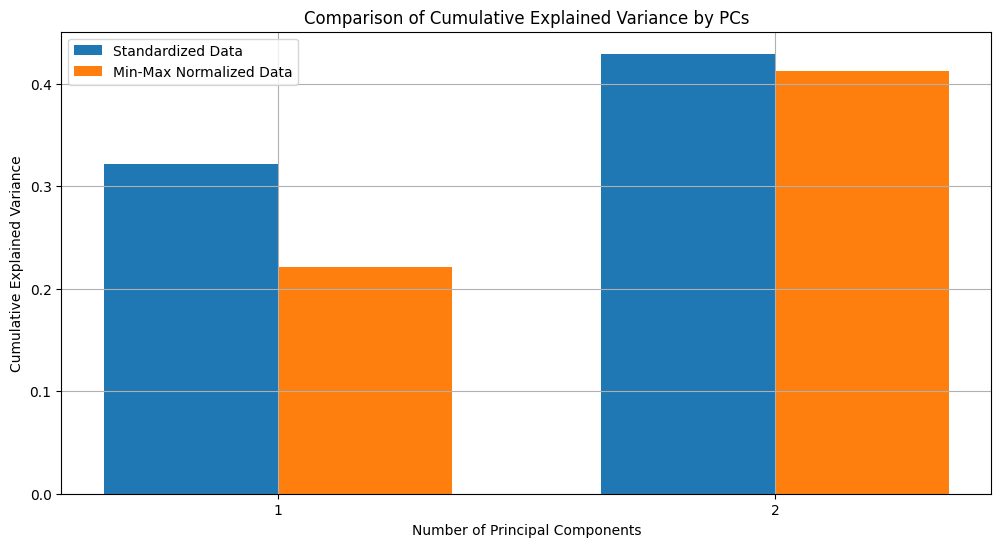

In [43]:
variance_threshold = 0.33
num_pcs_std = np.argmax(cumulative_explained_variance_std >= variance_threshold) + 1
num_pcs_mm = np.argmax(cumulative_explained_variance_mm >= variance_threshold) + 1

m_std = min(num_pcs_std, 5)
m_mm = min(num_pcs_mm, 5)
print(f"Number of PCs for StandardScaler: {m_std}")
print(f"Number of PCs for MinMaxScaler: {m_mm}")

pca_std = PCA(n_components=m_std)
pca_mm = PCA(n_components=m_mm)

X_std_pca = pca_std.fit_transform(Xworkdf_std)
X_mm_pca = pca_mm.fit_transform(Xworkdf_mm)

cumulative_explained_variance_std = np.cumsum(pca_std.explained_variance_ratio_)
cumulative_explained_variance_mm = np.cumsum(pca_mm.explained_variance_ratio_)
# TODO fix comments
# Plot the cumulative explained variance
# Assuming cumulative_explained_variance_std and cumulative_explained_variance_mm are already computed
num_pcs = max(len(cumulative_explained_variance_std), len(cumulative_explained_variance_mm))
indices = np.arange(1, num_pcs + 1)

# Setting the width for bar plots
bar_width = 0.35

# Plot
plt.figure(figsize=(12, 6))
bar1 = plt.bar(indices - bar_width / 2, cumulative_explained_variance_std[:num_pcs], bar_width,
               label='Standardized Data')
bar2 = plt.bar(indices + bar_width / 2, cumulative_explained_variance_mm[:num_pcs], bar_width,
               label='Min-Max Normalized Data')

plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Comparison of Cumulative Explained Variance by PCs')
plt.xticks(indices)
plt.legend()
plt.grid(True)
plt.show()

Interpreting and naming the Principal Components (PCs) requires an understanding of how the original features contribute to each PC. This is typically done by looking at the loadings (or weights) of each feature in the PCs. The loadings indicate how much each feature contributes to the variance captured by the PC.

## Extract Dominant Features and Create a Summary Table

In [44]:
def get_dominant_features(pca, feature_names, num_top_features=3):
    """
    Function to identify dominant features for each principal component.
    :param pca: Fitted PCA object
    :param feature_names: List of original feature names
    :param num_top_features: Number of top features to list for each component
    :return: DataFrame with dominant features for each PC
    """
    components = pca.components_
    dominant_features = []

    for i, pc in enumerate(components):
        component_loadings = zip(feature_names, pc)
        sorted_features = sorted(component_loadings, key=lambda x: abs(x[1]), reverse=True)
        top_features = sorted_features[:num_top_features]
        dominant_features.append([f"{feature[0]} ({feature[1]:.2f})" for feature in top_features])

    return pd.DataFrame(dominant_features, index=[f'PC{i + 1}' for i in range(len(components))])


def create_summary_table(pca, dominant_features):
    """
    Function to create a summary table for PCA results.
    :param pca: Fitted PCA object
    :param dominant_features: DataFrame with dominant features for each PC
    :return: Summary DataFrame
    """
    explained_variance = [f"{var:.2%}" for var in pca.explained_variance_ratio_]
    summary_df = pd.DataFrame({
        'Principal Component': dominant_features.index,
        'Explained Variance': explained_variance,
        'Dominant Features': dominant_features.values.tolist()
    })
    return summary_df



In [45]:
dominant_features_std = get_dominant_features(pca_std, features)
dominant_features_mm = get_dominant_features(pca_mm, features)

summary_table_std = create_summary_table(pca_std, dominant_features_std)
summary_table_mm = create_summary_table(pca_mm, dominant_features_mm)

In [46]:
summary_table_std
# TODO add interpretation for this table 

,Principal Component,Explained Variance,Dominant Features
0,PC1,32.19%,"[NumCatalogPurchases (0.34), MntMeatProducts (..."
1,PC2,10.75%,"[Dt_Customer_Year (0.59), Dt_Customer_Month (-..."


In [47]:
summary_table_mm
# TODO add interpretation for this table 

,Principal Component,Explained Variance,Dominant Features
0,PC1,22.13%,"[Dt_Customer_Year (-0.46), NumStorePurchases (..."
1,PC2,19.16%,"[Dt_Customer_Year (0.59), Dt_Customer_Month (-..."


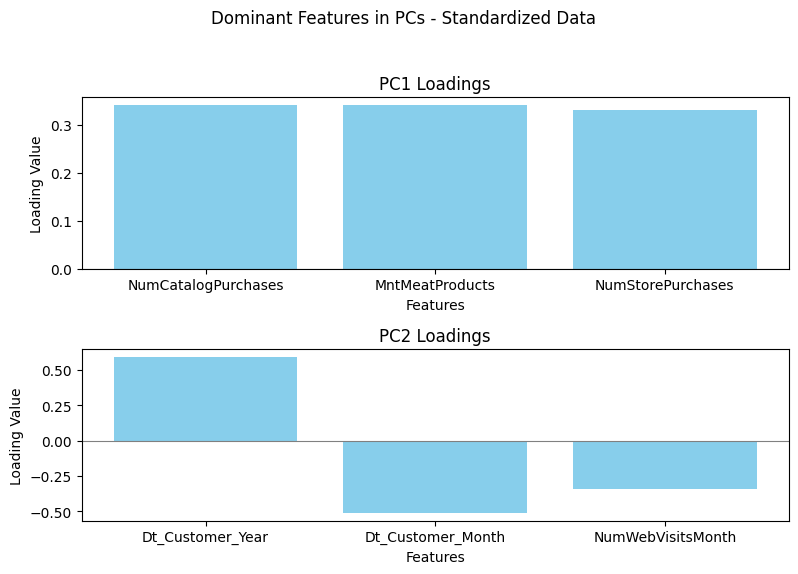

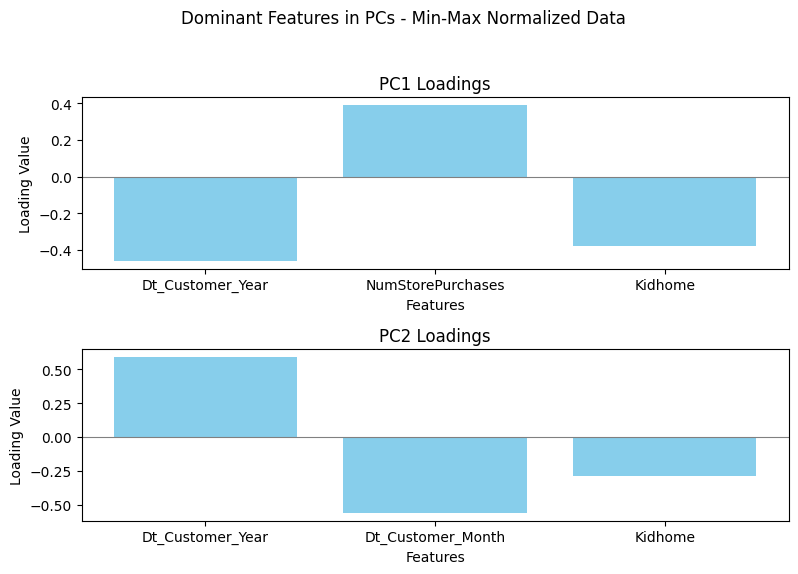

In [48]:
def plot_dominant_features(dominant_features, title):
    """
    Plot the dominant features and their loadings for each principal component.
    :param dominant_features: DataFrame with dominant features and their loadings
    :param title: Title for the plot
    """
    fig, axes = plt.subplots(nrows=len(dominant_features), ncols=1, figsize=(8, len(dominant_features) * 3))

    if len(dominant_features) == 1:
        axes = [axes]  # Ensure axes is always a list

    for i, pc in enumerate(dominant_features.index):
        pc_data = dominant_features.loc[pc]
        labels, loadings = zip(*[feature.split(' (') for feature in pc_data])
        loadings = [float(loading.replace(')', '')) for loading in loadings]

        axes[i].bar(labels, loadings, color='skyblue')
        axes[i].set_title(f'{pc} Loadings')
        axes[i].set_xlabel('Features')
        axes[i].set_ylabel('Loading Value')
        axes[i].axhline(0, color='gray', linewidth=0.8)

    plt.suptitle(title)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


# Example usage
plot_dominant_features(dominant_features_std, 'Dominant Features in PCs - Standardized Data')
plot_dominant_features(dominant_features_mm, 'Dominant Features in PCs - Min-Max Normalized Data')


The numbers associated with each feature in the output for dominant features, like `[NumCatalogPurchases (0.34), MntMeatProducts (0.34)]`, represent the loadings (or coefficients) of the features in the Principal Component (PC). 

In PCA, each original feature contributes to each principal component to a certain degree, which is quantified by these loadings. The loading of a feature in a principal component is a measure of:

1. **Magnitude (Value):** Indicates how strongly the feature influences the principal component. A higher absolute value of the loading means the feature has a stronger influence on the component.
   
2. **Direction (Sign):**
   - A **positive loading** (e.g., `0.34`) suggests that as the feature value increases, the principal component value also increases.
   - A **negative loading** (e.g., `-0.51`) implies that as the feature value increases, the principal component value decreases.

In your example:
- For the first PC, both `NumCatalogPurchases` and `MntMeatProducts` have loadings of approximately `0.34`. This means these features have a similar and positive influence on the first principal component. Their relatively high loading values indicate they are significant contributors to the variance this component captures.
  
- For the second PC, `Dt_Customer_Year` has a positive loading of `0.59`, and `Dt_Customer_Month` has a negative loading of `-0.51`. This means `Dt_Customer_Year` positively influences this component, while `Dt_Customer_Month` influences it in the opposite direction. The magnitude of these loadings suggests they are both important in defining the second principal component.

These loadings help in interpreting the principal components by understanding which features (and how they) contribute to the variance explained by each component.

In [49]:
# TODO redo the text that we wrote above to make it better
# TODO create some names for each PC based on the dominant features of that PC try to justify the names

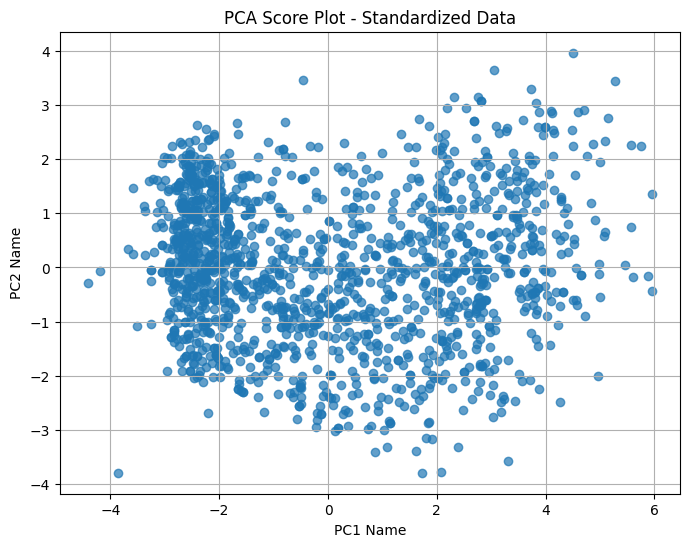

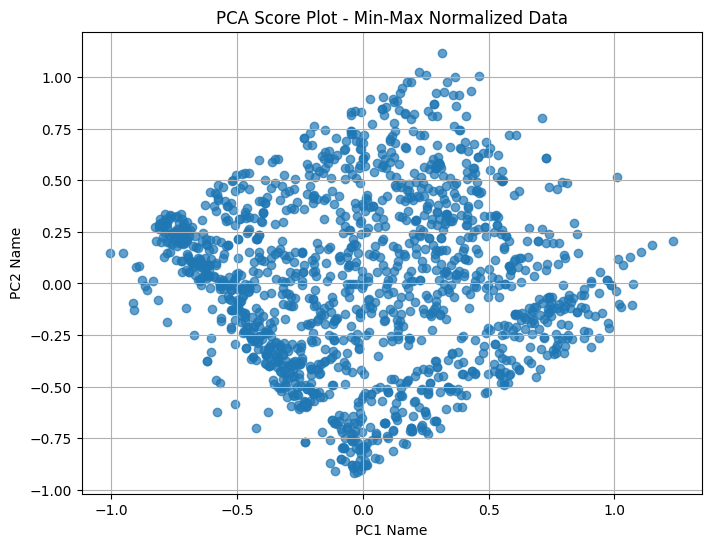

In [50]:
import matplotlib.cm as cm
def plot_pca_scores(pca_scores, pc_names, title):
    """
    Plot the PCA scores for the first two principal components.
    :param pca_scores: Array of PCA scores (transformed features)
    :param pc_names: List of names for the first two principal components
    :param title: Title for the plot
    """
    # unique_labels = np.unique(labels)
    # colors = cm.jet(np.linspace(0, 1, len(unique_labels)))
    plt.figure(figsize=(8, 6))
    plt.scatter(pca_scores[:, 0], pca_scores[:, 1], alpha=0.7)
    plt.xlabel(pc_names[0])
    plt.ylabel(pc_names[1])
    plt.title(title)
    plt.grid(True)
    plt.show()

# Assuming X_std_pca and X_mm_pca are your PCA-transformed features
# Replace 'PC1 Name' and 'PC2 Name' with your chosen names
plot_pca_scores(X_std_pca, ['PC1 Name', 'PC2 Name'], 'PCA Score Plot - Standardized Data')
plot_pca_scores(X_mm_pca, ['PC1 Name', 'PC2 Name'], 'PCA Score Plot - Min-Max Normalized Data')
